In [ ]:
# Import required package
using DifferentialEquations
using COBREXA
using DataFrames
using Tulip
using Plots
using Colors
using ModelingToolkit
using Statistics
using GLM
using Random
using Flux
using ProgressMeter
using MLBase #Confusion matrix function
using Serialization
using TreeParzen
using CSV
using LatinHypercubeSampling

home_path = "C:/Users/Charlotte/OneDrive - University of Edinburgh/Documents/research/joint-simulator/"
include(home_path * "models/beta_carotene.jl")
include(home_path * "beta_carotene/bcar_sim.jl")

println("Imports completed")

In [39]:
using COBREXA
using Tulip
using DataFrames
using Plots

In [17]:
model = load_model(StandardModel, "C:/Users/Charlotte/OneDrive - University of Edinburgh/Documents/research/joint-simulator/models/iML1515.xml")
reaction = Reaction("pathway", Dict("M_frdp_c" => -1.0, "M_ipdp_c" => -1.0))
reaction.lb = 0.0 #Must include lower bound to avoid reaction running backwards with -1000 flux
add_reactions!(model, [reaction])
model.reactions["R_EX_glc__D_e"].lb = 0.0
model.reactions["R_EX_fru_e"].lb = -7.5 #--> results in 0.65 growth rate

-7.5

In [32]:
v_p = 0.808
fluxes = flux_balance_analysis_dict(model, Tulip.Optimizer, modifications = [change_constraint("pathway", lb = v_p, ub = v_p)])
lam = fluxes["R_BIOMASS_Ec_iML1515_core_75p37M"]
v_fpp = -fluxes["R_UDCPDPS"] - fluxes["R_HEMEOS"] - fluxes["R_OCTDPS"]
v_ipp = -8.0*fluxes["R_UDCPDPS"] -5.0*fluxes["R_OCTDPS"] - fluxes["R_IPDDI"] - fluxes["R_DMATT"] + fluxes["R_IPDPS"]

println("IPP net flux: ", round(v_ipp, digits=5))
println("FPP efflux: ", round(v_fpp, digits=5))
println("Growth rate: ", round(lam, digits=5))
println("GRTT: ", round(fluxes["R_GRTT"], digits=3))

println()
println("y = ", -8.0*fluxes["R_UDCPDPS"] -5.0*fluxes["R_OCTDPS"] - fluxes["R_DMATT"])
println("p = ",  fluxes["R_IPDPS"]/(- fluxes["R_IPDDI"] + fluxes["R_IPDPS"]))
println("e = ",  -fluxes["R_UDCPDPS"] - fluxes["R_HEMEOS"] - fluxes["R_OCTDPS"])
println("lam = ", lam)

IPP net flux: 1.61608
FPP efflux: -8.0e-5
Growth rate: 0.27593
GRTT: 0.808

y = -0.8085057732195183
p = 0.7775443786917364
e = -7.670755974697931e-5
lam = 0.2759264821557277


In [57]:
data = DataFrame()
for v_p in LinRange(0, 1.0, 500)
    fluxes = flux_balance_analysis_dict(model, Tulip.Optimizer, modifications = [change_constraint("pathway", lb = v_p, ub = v_p)])
    if typeof(fluxes) != Nothing
        lam = fluxes["R_BIOMASS_Ec_iML1515_core_75p37M"]
        v_fpp = -fluxes["R_UDCPDPS"] - fluxes["R_HEMEOS"] - fluxes["R_OCTDPS"]
        v_ipp = -8.0*fluxes["R_UDCPDPS"] -5.0*fluxes["R_OCTDPS"] - fluxes["R_IPDDI"] - fluxes["R_DMATT"] + fluxes["R_IPDPS"]
        y = -8.0*fluxes["R_UDCPDPS"] -5.0*fluxes["R_OCTDPS"] - fluxes["R_DMATT"]
        p = fluxes["R_IPDPS"]/(- fluxes["R_IPDDI"] + fluxes["R_IPDPS"])
        e = -fluxes["R_UDCPDPS"] - fluxes["R_HEMEOS"] - fluxes["R_OCTDPS"]
        ipdps = -fluxes["R_IPDPS"]
        ipddi = fluxes["R_IPDDI"]

        data = vcat(data, DataFrame("v_p" => [v_p], "y" => [y], "lam" => [lam], "p" => [p], "e" => [e], "feas" => [1], "ipdps" => [ipdps], "ipddi" => [ipddi]))
    else
        data = vcat(data, DataFrame("v_p" => [v_p], "y" => [NaN], "lam" => [NaN], "p" => [NaN], "e" => [NaN], "feas" => [0], "ipdps" =>[NaN], "ipddi" => [NaN]))
    end
end

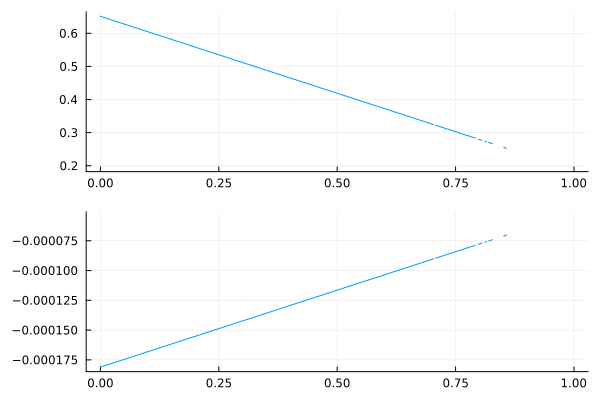

In [58]:
plot(data.v_p, [data.lam data.e], layout=(2, 1), legend=false)

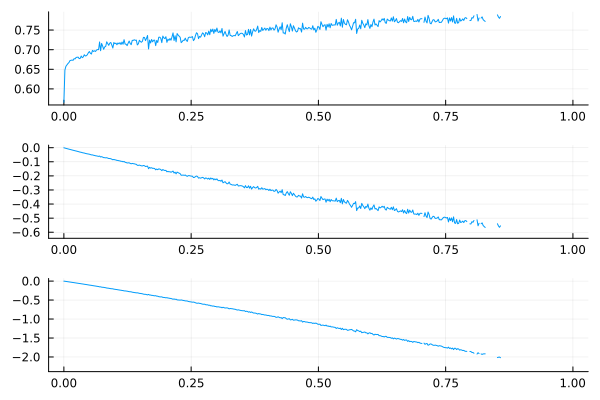

In [59]:
plot(data.v_p, [data.p data.ipddi data.ipdps], layout=(3, 1), legend=false)


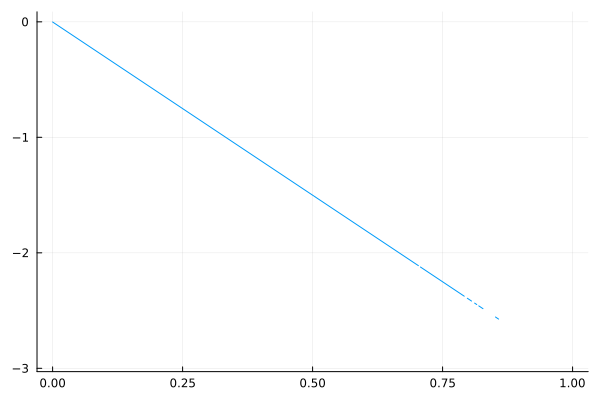

In [60]:
plot(data.v_p,data.ipddi+data.ipdps, legend=false)
